<a href="https://colab.research.google.com/github/milicasopalovic/RI_rokovi/blob/main/mobile_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://gitlab.com/milicasopalovic/ip2-projekat.git

Cloning into 'ip2-projekat'...
remote: Enumerating objects: 10572, done.
remote: Counting objects: 100% (6884/6884), done.
remote: Compressing objects: 100% (6883/6883), done.
remote: Total 10572 (delta 2), reused 6877 (delta 1), pack-reused 3688 (from 1)
Receiving objects: 100% (10572/10572), 157.36 MiB | 16.45 MiB/s, done.
Resolving deltas: 100% (200/200), done.
Updating files: 100% (14601/14601), done.


In [2]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import load_img, img_to_array, save_img, image_dataset_from_directory
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from collections import Counter
import cv2
import imghdr
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

<ipython-input-2-2871b730e5d6>:11: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trening_dir = './ip2-projekat/skup_podataka_original/trening'
test_dir = './ip2-projekat/skup_podataka_original/test'

batch_size = 32
img_height, img_width = 224, 224

# Kreiranje ImageDataGenerator-a sa normalizacijom
datagen = ImageDataGenerator(rescale=1.0 / 255.0, validation_split=0.2)

# Generator za trening (80% podataka)
train_generator = datagen.flow_from_directory(
    trening_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Deo za trening
)

# Generator za validaciju (20% podataka)
validation_generator = datagen.flow_from_directory(
    trening_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,  # Nije potrebno mešanje
    subset='validation'  # Deo za validaciju
)

# Generator za test skup (bez podele)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Test ne mešamo da bismo dobili tačne metrike
)


Found 1029 images belonging to 37 classes.
Found 240 images belonging to 37 classes.
Found 571 images belonging to 37 classes.


In [5]:
from sklearn.utils.class_weight import compute_class_weight


# Imena klasa i njihovi indeksi
imena_klasa = list(train_generator.class_indices.keys())
print("Klase:", imena_klasa)

# Prebrojavanje uzoraka po klasama
broj_uzoraka_po_klasi = train_generator.classes  # Lista klasa za svaku sliku
print("Broj uzoraka po klasama:", np.bincount(broj_uzoraka_po_klasi))

# Izračunavanje težina klasa
tezine_klasa = compute_class_weight(
    class_weight='balanced',  # Balansiranje na osnovu broja uzoraka
    classes=np.unique(broj_uzoraka_po_klasi),
    y=broj_uzoraka_po_klasi
)
tezine_klasa = dict(enumerate(tezine_klasa))  # Konverzija u format koji fit() razume
print("Težine klasa:", tezine_klasa)


Klase: ['aenar', 'andorian', 'antedian', 'arcadian', 'arcturian', 'axanar', 'bajoran', 'benzite', 'bolian', 'borg', 'breen', 'brikar', 'cardassian', 'changeling', 'deltan', 'denobulan', 'dosi', 'ferengi', 'gorn', 'hirogen', 'human', "jem'Hadar", 'kazon', 'kelpien', 'klingon', 'orion', 'pakled', 'reman', 'romulan', 'talaxian', 'talosians', 'tellarite', 'trill', 'vidiians', 'vortas', 'vulcan', 'xindi']
Broj uzoraka po klasama: [ 32  37  16  15   9   4  42  24  51  32  22  24  44  36  35  30  17  60
  54  29 129  18  15  17  14  15  14  14  15  12  18  14  17  16  13  30
  45]
Težine klasa: {0: 0.8690878378378378, 1: 0.7516435354273192, 2: 1.7381756756756757, 3: 1.854054054054054, 4: 3.09009009009009, 5: 6.952702702702703, 6: 0.6621621621621622, 7: 1.1587837837837838, 8: 0.5453100158982512, 9: 0.8690878378378378, 10: 1.2641277641277642, 11: 1.1587837837837838, 12: 0.6320638820638821, 13: 0.7725225225225225, 14: 0.7945945945945946, 15: 0.927027027027027, 16: 1.6359300476947536, 17: 0.46351

In [7]:
from tensorflow.keras.applications import MobileNetV2
# Postavke
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam  # Ovo je nedostajalo!

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Zamrzni slojeve

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(37, activation='softmax')
])

In [8]:
model.compile(
    optimizer='adam',  # Možeš zameniti sa SGD ili RMSprop, zavisno od problema
    loss='categorical_crossentropy',  # Koristi ovu funkciju jer imaš više klasa
    metrics=['accuracy']
)


In [9]:
history = model.fit(
    train_generator,
    epochs=20,  # Broj epoha
        class_weight=tezine_klasa,
        validation_data = validation_generator,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 406ms/step - accuracy: 0.0789 - loss: 3.7151 - val_accuracy: 0.3833 - val_loss: 2.7077 - learning_rate: 0.0010
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.3031 - loss: 2.5859 - val_accuracy: 0.5167 - val_loss: 2.0785 - learning_rate: 0.0010
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.4899 - loss: 1.9202 - val_accuracy: 0.5583 - val_loss: 1.7194 - learning_rate: 0.0010
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.6141 - loss: 1.3034 - val_accuracy: 0.6167 - val_loss: 1.5502 - learning_rate: 0.0010
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.6879 - loss: 0.9957 - val_accuracy: 0.6292 - val_loss: 1.2786 - learning_rate: 0.0010
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.7659 - loss: 0.7517 - val_accuracy: 0.6542 - val_loss: 1.1425 - learning_rate: 0.0010
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.8102 - loss: 0.5903 - val_

In [10]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test gubitak: {test_loss:.4f}")
print(f"Test tačnost: {test_accuracy:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - accuracy: 0.8209 - loss: 0.6630
Test gubitak: 0.8069
Test tačnost: 0.7723


In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predikcije modela za test skup
predikcije = np.argmax(model.predict(test_generator), axis=-1)


# Pretvaranje stvarnih vrednosti u indekse (ako su one u one-hot kodiranju)
stvarno = test_generator.classes

# Izračunavanje matrice konfuzije
matrica_konfuzije = confusion_matrix(stvarno, predikcije)

# Provera da li je matrica konfuzije dobro izračunata
print(f"Dimenzije matrice konfuzije: {matrica_konfuzije.shape}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step
Dimenzije matrice konfuzije: (37, 37)


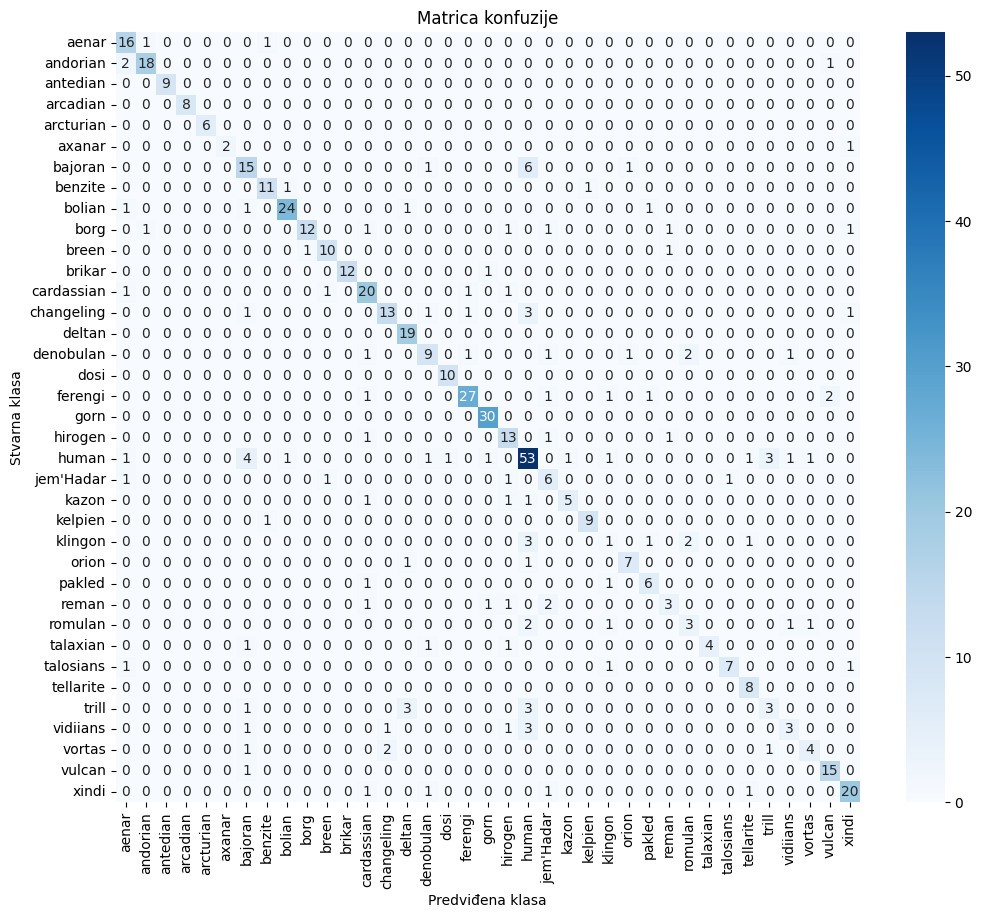

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Definisanje svih klasa
sortirani_nazivi_klasa = sorted(os.listdir(test_dir))
class_names = sortirani_nazivi_klasa  # Sortiranje klasa

# Kreiranje DataFrame-a za matricu konfuzije
matrica_df = pd.DataFrame(matrica_konfuzije, index=class_names, columns=class_names)

# Prikazivanje matrice konfuzije
plt.figure(figsize=(12, 10))
sns.heatmap(matrica_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predviđena klasa')
plt.ylabel('Stvarna klasa')
plt.title('Matrica konfuzije')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator



trening_dir = './ip2-projekat/skup_podataka_vestacki/trening'
test_dir = './ip2-projekat/skup_podataka_vestacki/test'

batch_size = 32
img_height, img_width = 224, 224

# Kreiranje ImageDataGenerator-a sa normalizacijom
datagen = ImageDataGenerator(rescale=1.0 / 255.0, validation_split=0.2)

# Generator za trening (80% podataka)
train_generator = datagen.flow_from_directory(
    trening_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Deo za trening
)

# Generator za validaciju (20% podataka)
validation_generator = datagen.flow_from_directory(
    trening_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,  # Nije potrebno mešanje
    subset='validation'  # Deo za validaciju
)

# Generator za test skup (bez podele)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Test ne mešamo da bismo dobili tačne metrike
)


Found 5000 images belonging to 37 classes.
Found 1231 images belonging to 37 classes.
Found 2843 images belonging to 37 classes.


In [16]:
history = model.fit(
    train_generator,
    epochs=20,  # Broj epoha
        validation_data = validation_generator,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - accuracy: 0.6422 - loss: 1.2438 - val_accuracy: 0.8067 - val_loss: 0.6290 - learning_rate: 0.0010
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.7455 - loss: 0.8321 - val_accuracy: 0.8578 - val_loss: 0.4903 - learning_rate: 0.0010
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.8106 - loss: 0.6248 - val_accuracy: 0.8928 - val_loss: 0.4057 - learning_rate: 0.0010
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.8442 - loss: 0.4876 - val_accuracy: 0.8976 - val_loss: 0.3568 - learning_rate: 0.0010
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.8792 - loss: 0.3932 - val_accuracy: 0.9033 - val_loss: 0.3224 - learning_rate: 0.0010
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.8870 - loss: 0.3477 - val_accuracy: 0.9115 - val_loss: 0.3106 - learning_rate: 0.0010
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9053 - 

In [17]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test gubitak: {test_loss:.4f}")
print(f"Test tačnost: {test_accuracy:.4f}")


89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.8207 - loss: 0.7835
Test gubitak: 0.8468
Test tačnost: 0.7932


In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predikcije modela za test skup
predikcije = np.argmax(model.predict(test_generator), axis=-1)


# Pretvaranje stvarnih vrednosti u indekse (ako su one u one-hot kodiranju)
stvarno = test_generator.classes

# Izračunavanje matrice konfuzije
matrica_konfuzije = confusion_matrix(stvarno, predikcije)

# Provera da li je matrica konfuzije dobro izračunata
print(f"Dimenzije matrice konfuzije: {matrica_konfuzije.shape}")

89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step
Dimenzije matrice konfuzije: (37, 37)


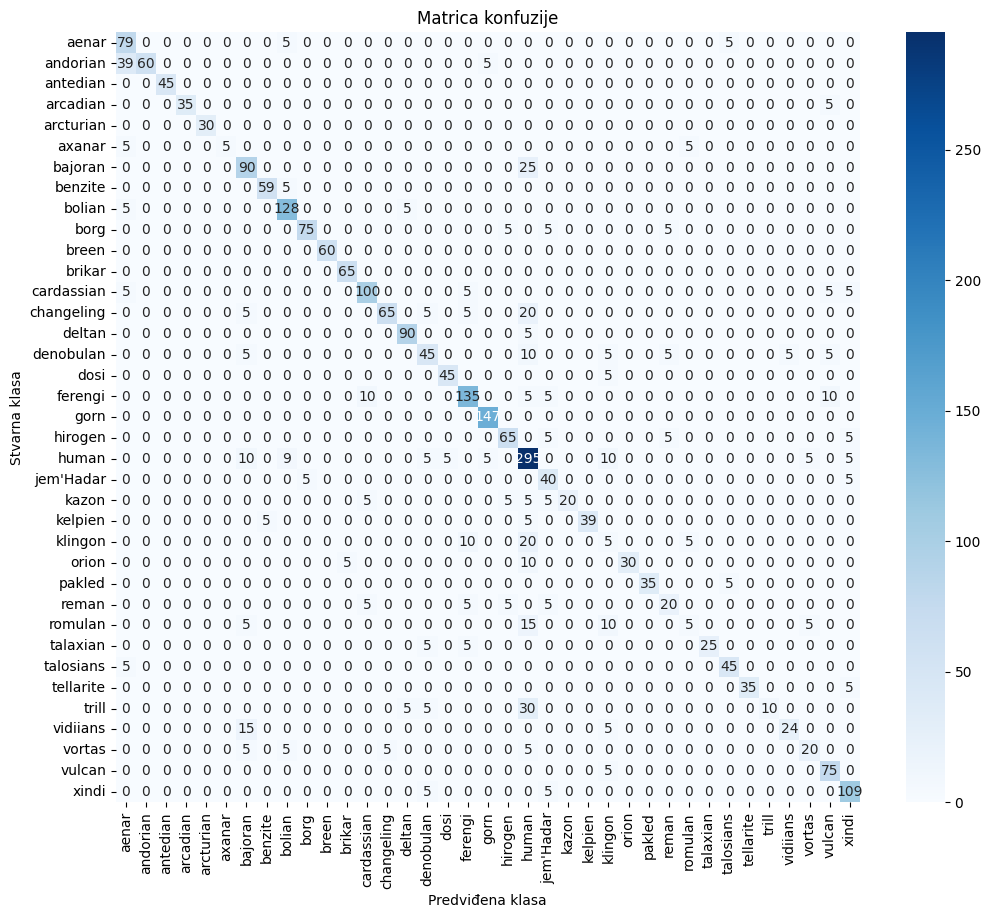

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Definisanje svih klasa
sortirani_nazivi_klasa = sorted(os.listdir(test_dir))
class_names = sortirani_nazivi_klasa  # Sortiranje klasa

# Kreiranje DataFrame-a za matricu konfuzije
matrica_df = pd.DataFrame(matrica_konfuzije, index=class_names, columns=class_names)

# Prikazivanje matrice konfuzije
plt.figure(figsize=(12, 10))
sns.heatmap(matrica_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predviđena klasa')
plt.ylabel('Stvarna klasa')
plt.title('Matrica konfuzije')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()